# install library

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Mounted at /content/drive


In [2]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

    #一回のみ
    # !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    # !mkdir -p ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2
    # !unzip -n -qq animal-imbalance-classification-round2.zip -d ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2

    !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    !mkdir -p ../input/animal-imbalance-classification-round2
    !unzip -n -qq animal-imbalance-classification-round2.zip -d ../input/animal-imbalance-classification-round2


Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 4.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=6753706136ba247a01d4b53b0555791b7cb06cbc3ccefa478a7ed060b5065e4c
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
 63% 9.00M/14.3M [00:00<00:00, 12.6MB/s]
100% 14.3M/14.3M [00:00<00:00, 17.2MB/s]
 98% 115M/117M [00:03<00:00, 41.6MB/s]
100% 117M/117M [00:03<00:00, 33.1MB/s]


In [3]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

from pathlib import Path
from PIL import Image

#import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

import timm
warnings.filterwarnings('ignore')

     |████████████████████████████████| 117 kB 12.4 MB/s 
     |████████████████████████████████| 948 kB 42.0 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=e55860fa20c7ca1c63be296eccb401ff6ee9a31792b21ff550b0ac72a331e397
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Config


In [4]:
class Config:
    Version = "exp26" # model save時のversion
    #MODEL_NAME = "resnet34" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b1" # モデル名
    #MODEL_NAME = "efficientnet_b2" # モデル名
    #MODEL_NAME = "efficientnet_b3" # モデル名
    #MODEL_NAME = "efficientnet_b4" # モデル名
    #MODEL_NAME = "efficientnet_b5" # モデル名
    #MODEL_NAME = "efficientnet_b6" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名
    #MODEL_NAME = "tf_efficientnet_b0_ns" # モデル名
    MODEL_NAME = "tf_efficientnet_b1_ns" # モデル名
    #MODEL_NAME = "tf_efficientnet_b2_ns" # モデル名
    #MODEL_NAME = "resnet50" # モデル名
    #MODEL_NAME = "swin_large_patch4_window7_224"
    #MODEL_NAME = "swin_base_patch4_window7_224"
    #MODEL_NAME = "swin_small_patch4_window7_224"
    #MODEL_NAME = "swin_large_patch4_window12_384"
    #MODEL_NAME = "swin_base_patch4_window12_384"


    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        #data_dir = '../input/digit-recognizer/' # = DATA_PATH
        data_dir = '../input/animal-imbalance-classification-round2' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance'
        data_dir = '../input/animal-imbalance-classification-round2' #os.path.join(base_dir, '../input/animal-imbalance-classification-round2')
        #pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 64 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_small_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b0':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b1':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b2':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b3':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b4':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b5':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b6':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5    
    elif MODEL_NAME == 'efficientnet_b7':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b0_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b1_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b2_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    fold = 0
    num_workers = 4  #並列実行する数 was 0
    batch_size =  64 #バッチサイズ was 64 >100
    epochs = 50 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 10 # 最大イテレーション数 was 10
    min_lr = 1e-3 # 学習率の最小値 was 1e-5
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    probability = 0.6
    class_num = 10 
    norms = (0.5, 0.5)
    alpha = 0.5
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [5]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [7]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [8]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [9]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        # self.data = []
        # self.targets = []

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']
        
        label = self.labels[idx] # 正解ラベル
        return image, label

In [10]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [11]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, p=0.5),
            A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Mixup

In [12]:
def mixup(x, y, alpha=Config.alpha):

    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

# Model

In [13]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.num_features#fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# train & valid function

In [14]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    #https://colab.research.google.com/github/tan5o/Data-Augmentation-Method-Comparison-of-Cifar-100/blob/master/cifer100_pytorch_mixup.ipynb#scrollTo=iSq4oO_zjpnI
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ

        mix_images, target_a, target_b, lam = mixup(images, labels, alpha=1.0)

        _imgs = mix_images.to('cpu').detach().numpy()
        imgs = np.transpose(_imgs, (0, 2, 3, 1))
        
        # mix_images = images.to(Config.device)
        # target_a = target_a.to(Config.device)
        # target_b = target_b.to(Config.device)

        batch_size = labels.size(0) 
        y_preds = model(mix_images) # 予測ラベル　model(mix_images) 
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [15]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [16]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']
else:
    train = pd.read_csv(f'{Config.data_dir}/train.csv')
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']

train.head()

image_id  label
0  ../input/animal-imbalance-classification-round...      0
1  ../input/animal-imbalance-classification-round...      0
2  ../input/animal-imbalance-classification-round...      0
3  ../input/animal-imbalance-classification-round...      0
4  ../input/animal-imbalance-classification-round...      0

In [17]:
#train['image_id'][0]

In [18]:
import plotly.express as px

target = train.label.value_counts()
#class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [19]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [20]:
f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
train["folds"] = -1
train.loc[f0.index, "folds"] = 1
train.loc[f1.index, "folds"] = 0
train

image_id  label  folds
0      ../input/animal-imbalance-classification-round...      0      1
1      ../input/animal-imbalance-classification-round...      0      1
2      ../input/animal-imbalance-classification-round...      0      1
3      ../input/animal-imbalance-classification-round...      0      1
4      ../input/animal-imbalance-classification-round...      0      0
...                                                  ...    ...    ...
36495  ../input/animal-imbalance-classification-round...      9      1
36496  ../input/animal-imbalance-classification-round...      9      1
36497  ../input/animal-imbalance-classification-round...      9      1
36498  ../input/animal-imbalance-classification-round...      9      1
36499  ../input/animal-imbalance-classification-round...      9      0

[36500 rows x 3 columns]

#### 平均と標準偏差を計算

In [21]:
#修正部分
# images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
# norms = (np.mean(images[train.folds!=0] / 255), np.std(images[train.folds!=0] / 255)) # 平均と標準偏差を計算
# print("平均と標準偏差: ", norms)

#### 画像サイズの確認と数例を表示

In [22]:
# norms = (0.5, 0.5)
# train_dataset = TrainDataset(train,transform=get_transforms(data='train', size=Config.size, norms=Config.norms)) # 学習用のdatasetを作成
# train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
# image_iter = iter(train_loader)
# images, labels = image_iter.next()

In [23]:
# print("height: ", images.shape[1])
# print("weight: ", images.shape[2])

# for n in range(3):
#     fig, axes = plt.subplots(1, 10, figsize=(20, 30))
#     [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

#     plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [24]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_runnin

### 最適化関数

In [25]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
#optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
#optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)


### スケジューラ

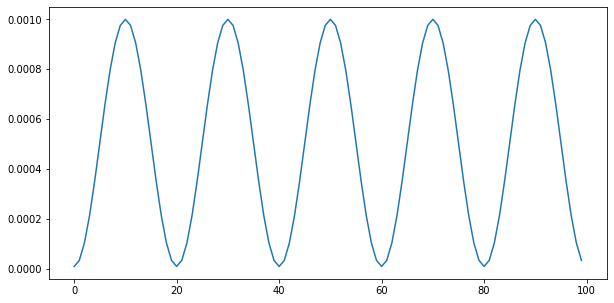

In [26]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

# 学習

In [27]:
def train_loop(train, fold, class_num=None, norms=(0.5, 0.5)):
    
    train_index = train[train['folds'] != fold].index # 学習用のindex
    valid_index = train[train['folds'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    #optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    #optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)

    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion = nn.CrossEntropyLoss() # loss function

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [28]:
preds = train_loop(train, fold=Config.fold, class_num=Config.class_num, norms=Config.norms)

Epoch: [1][0/456] Data 1.435 (1.435) Elapsed 0m 2s (remain 19m 1s) Loss: 2.2878(2.2878) 
Epoch: [1][455/456] Data 0.000 (0.004) Elapsed 2m 59s (remain 0m 0s) Loss: 2.2704(2.2908) 
EVAL: [0/115] Data 0.786 (0.786) Elapsed 0m 0s (remain 1m 47s) Loss: 2.1112(2.1112) 
EVAL: [114/115] Data 0.000 (0.023) Elapsed 0m 13s (remain 0m 0s) Loss: 2.4710(2.6369) 


Epoch 1 - avg_train_loss: 2.2908  avg_val_loss: 2.6369  time: 194s
Epoch 1 - Accuracy: 0.1447945205479452
Epoch 1 - Save Best Score: 0.1448 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [2][0/456] Data 0.922 (0.922) Elapsed 0m 1s (remain 12m 30s) Loss: 2.2543(2.2543) 
Epoch: [2][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.0704(2.1758) 
EVAL: [0/115] Data 0.644 (0.644) Elapsed 0m 0s (remain 1m 32s) Loss: 1.7947(1.7947) 
EVAL: [114/115] Data 0.000 (0.023) Elapsed 0m 13s (remain 0m 0s) Loss: 3.5202(3.7119) 


Epoch 2 - avg_train_loss: 2.1758  avg_val_loss: 3.7119  time: 186s
Epoch 2 - Accuracy: 0.21109589041095891
Epoch 2 - Save Best Score: 0.2111 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [3][0/456] Data 0.780 (0.780) Elapsed 0m 1s (remain 11m 50s) Loss: 2.1006(2.1006) 
Epoch: [3][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.3092(2.0258) 
EVAL: [0/115] Data 0.628 (0.628) Elapsed 0m 0s (remain 1m 28s) Loss: 1.4931(1.4931) 
EVAL: [114/115] Data 0.000 (0.024) Elapsed 0m 14s (remain 0m 0s) Loss: 4.3387(2.2263) 


Epoch 3 - avg_train_loss: 2.0258  avg_val_loss: 2.2263  time: 187s
Epoch 3 - Accuracy: 0.3156164383561644
Epoch 3 - Save Best Score: 0.3156 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [4][0/456] Data 0.854 (0.854) Elapsed 0m 1s (remain 12m 3s) Loss: 1.9423(1.9423) 
Epoch: [4][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.3741(1.9963) 
EVAL: [0/115] Data 0.766 (0.766) Elapsed 0m 0s (remain 1m 41s) Loss: 2.5612(2.5612) 
EVAL: [114/115] Data 0.000 (0.023) Elapsed 0m 13s (remain 0m 0s) Loss: 3.3487(2.1623) 


Epoch 4 - avg_train_loss: 1.9963  avg_val_loss: 2.1623  time: 187s
Epoch 4 - Accuracy: 0.35726027397260274
Epoch 4 - Save Best Score: 0.3573 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [5][0/456] Data 0.770 (0.770) Elapsed 0m 1s (remain 12m 11s) Loss: 1.8805(1.8805) 
Epoch: [5][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.3859(1.9637) 
EVAL: [0/115] Data 0.654 (0.654) Elapsed 0m 0s (remain 1m 29s) Loss: 1.7331(1.7331) 
EVAL: [114/115] Data 0.000 (0.024) Elapsed 0m 13s (remain 0m 0s) Loss: 3.4857(1.7869) 


Epoch 5 - avg_train_loss: 1.9637  avg_val_loss: 1.7869  time: 186s
Epoch 5 - Accuracy: 0.3987671232876712
Epoch 5 - Save Best Score: 0.3988 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [6][0/456] Data 0.887 (0.887) Elapsed 0m 1s (remain 12m 9s) Loss: 1.9316(1.9316) 
Epoch: [6][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.8253(1.9156) 
EVAL: [0/115] Data 0.814 (0.814) Elapsed 0m 0s (remain 1m 47s) Loss: 1.3836(1.3836) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 13s (remain 0m 0s) Loss: 3.3682(1.6401) 


Epoch 6 - avg_train_loss: 1.9156  avg_val_loss: 1.6401  time: 187s
Epoch 6 - Accuracy: 0.46095890410958906
Epoch 6 - Save Best Score: 0.4610 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [7][0/456] Data 0.924 (0.924) Elapsed 0m 1s (remain 12m 52s) Loss: 1.6208(1.6208) 
Epoch: [7][455/456] Data 0.000 (0.002) Elapsed 2m 52s (remain 0m 0s) Loss: 2.2131(1.8977) 
EVAL: [0/115] Data 0.607 (0.607) Elapsed 0m 0s (remain 1m 25s) Loss: 1.2009(1.2009) 
EVAL: [114/115] Data 0.000 (0.021) Elapsed 0m 13s (remain 0m 0s) Loss: 2.6904(1.4353) 


Epoch 7 - avg_train_loss: 1.8977  avg_val_loss: 1.4353  time: 186s
Epoch 7 - Accuracy: 0.5095890410958904
Epoch 7 - Save Best Score: 0.5096 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [8][0/456] Data 0.798 (0.798) Elapsed 0m 1s (remain 12m 5s) Loss: 1.5251(1.5251) 
Epoch: [8][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.0084(1.8736) 
EVAL: [0/115] Data 0.786 (0.786) Elapsed 0m 0s (remain 1m 42s) Loss: 0.9357(0.9357) 
EVAL: [114/115] Data 0.000 (0.024) Elapsed 0m 13s (remain 0m 0s) Loss: 3.2916(1.4224) 


Epoch 8 - avg_train_loss: 1.8736  avg_val_loss: 1.4224  time: 187s
Epoch 8 - Accuracy: 0.5234246575342466
Epoch 8 - Save Best Score: 0.5234 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [9][0/456] Data 0.866 (0.866) Elapsed 0m 1s (remain 11m 44s) Loss: 1.4769(1.4769) 
Epoch: [9][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.4903(1.8695) 
EVAL: [0/115] Data 0.776 (0.776) Elapsed 0m 0s (remain 1m 44s) Loss: 1.0008(1.0008) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 14s (remain 0m 0s) Loss: 3.1592(1.4814) 


Epoch 9 - avg_train_loss: 1.8695  avg_val_loss: 1.4814  time: 187s
Epoch 9 - Accuracy: 0.5143835616438356


Epoch: [10][0/456] Data 0.885 (0.885) Elapsed 0m 1s (remain 12m 4s) Loss: 1.5008(1.5008) 
Epoch: [10][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.0351(1.8187) 
EVAL: [0/115] Data 0.781 (0.781) Elapsed 0m 0s (remain 1m 41s) Loss: 1.0101(1.0101) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 14s (remain 0m 0s) Loss: 3.1839(1.4158) 


Epoch 10 - avg_train_loss: 1.8187  avg_val_loss: 1.4158  time: 187s
Epoch 10 - Accuracy: 0.5616438356164384
Epoch 10 - Save Best Score: 0.5616 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [11][0/456] Data 0.817 (0.817) Elapsed 0m 1s (remain 12m 12s) Loss: 1.4752(1.4752) 
Epoch: [11][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.6585(1.8190) 
EVAL: [0/115] Data 0.680 (0.680) Elapsed 0m 0s (remain 1m 31s) Loss: 1.0899(1.0899) 
EVAL: [114/115] Data 0.000 (0.027) Elapsed 0m 13s (remain 0m 0s) Loss: 2.8039(1.3451) 


Epoch 11 - avg_train_loss: 1.8190  avg_val_loss: 1.3451  time: 187s
Epoch 11 - Accuracy: 0.589041095890411
Epoch 11 - Save Best Score: 0.5890 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [12][0/456] Data 0.726 (0.726) Elapsed 0m 1s (remain 11m 43s) Loss: 2.3362(2.3362) 
Epoch: [12][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.3984(1.8105) 
EVAL: [0/115] Data 0.733 (0.733) Elapsed 0m 0s (remain 1m 35s) Loss: 1.1077(1.1077) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 13s (remain 0m 0s) Loss: 2.5162(1.3218) 


Epoch 12 - avg_train_loss: 1.8105  avg_val_loss: 1.3218  time: 187s
Epoch 12 - Accuracy: 0.5917808219178082
Epoch 12 - Save Best Score: 0.5918 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [13][0/456] Data 1.033 (1.033) Elapsed 0m 1s (remain 12m 43s) Loss: 1.2529(1.2529) 
Epoch: [13][455/456] Data 0.000 (0.003) Elapsed 2m 52s (remain 0m 0s) Loss: 2.0755(1.7699) 
EVAL: [0/115] Data 0.604 (0.604) Elapsed 0m 0s (remain 1m 27s) Loss: 1.0124(1.0124) 
EVAL: [114/115] Data 0.000 (0.023) Elapsed 0m 13s (remain 0m 0s) Loss: 3.7538(1.2775) 


Epoch 13 - avg_train_loss: 1.7699  avg_val_loss: 1.2775  time: 187s
Epoch 13 - Accuracy: 0.5813698630136986


Epoch: [14][0/456] Data 0.722 (0.722) Elapsed 0m 1s (remain 11m 13s) Loss: 2.5297(2.5297) 
Epoch: [14][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.2244(1.7879) 
EVAL: [0/115] Data 0.530 (0.530) Elapsed 0m 0s (remain 1m 9s) Loss: 1.1818(1.1818) 
EVAL: [114/115] Data 0.000 (0.026) Elapsed 0m 13s (remain 0m 0s) Loss: 2.4246(1.2192) 


Epoch 14 - avg_train_loss: 1.7879  avg_val_loss: 1.2192  time: 187s
Epoch 14 - Accuracy: 0.6164383561643836
Epoch 14 - Save Best Score: 0.6164 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [15][0/456] Data 0.966 (0.966) Elapsed 0m 1s (remain 12m 7s) Loss: 2.2315(2.2315) 
Epoch: [15][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.8779(1.7721) 
EVAL: [0/115] Data 0.422 (0.422) Elapsed 0m 0s (remain 0m 58s) Loss: 1.0756(1.0756) 
EVAL: [114/115] Data 0.000 (0.024) Elapsed 0m 13s (remain 0m 0s) Loss: 2.1712(1.2668) 


Epoch 15 - avg_train_loss: 1.7721  avg_val_loss: 1.2668  time: 186s
Epoch 15 - Accuracy: 0.6334246575342466
Epoch 15 - Save Best Score: 0.6334 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [16][0/456] Data 0.827 (0.827) Elapsed 0m 1s (remain 12m 11s) Loss: 1.3327(1.3327) 
Epoch: [16][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.6502(1.7348) 
EVAL: [0/115] Data 0.587 (0.587) Elapsed 0m 0s (remain 1m 23s) Loss: 0.8777(0.8777) 
EVAL: [114/115] Data 0.000 (0.023) Elapsed 0m 13s (remain 0m 0s) Loss: 1.4850(1.1494) 


Epoch 16 - avg_train_loss: 1.7348  avg_val_loss: 1.1494  time: 186s
Epoch 16 - Accuracy: 0.6663013698630137
Epoch 16 - Save Best Score: 0.6663 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [17][0/456] Data 0.755 (0.755) Elapsed 0m 1s (remain 11m 46s) Loss: 1.3961(1.3961) 
Epoch: [17][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.0001(1.7316) 
EVAL: [0/115] Data 0.758 (0.758) Elapsed 0m 0s (remain 1m 39s) Loss: 0.9843(0.9843) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 13s (remain 0m 0s) Loss: 1.3750(1.1519) 


Epoch 17 - avg_train_loss: 1.7316  avg_val_loss: 1.1519  time: 186s
Epoch 17 - Accuracy: 0.665068493150685


Epoch: [18][0/456] Data 0.761 (0.761) Elapsed 0m 1s (remain 11m 40s) Loss: 2.3554(2.3554) 
Epoch: [18][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.5865(1.6823) 
EVAL: [0/115] Data 0.658 (0.658) Elapsed 0m 0s (remain 1m 29s) Loss: 0.7645(0.7645) 
EVAL: [114/115] Data 0.000 (0.026) Elapsed 0m 13s (remain 0m 0s) Loss: 1.9627(1.0949) 


Epoch 18 - avg_train_loss: 1.6823  avg_val_loss: 1.0949  time: 186s
Epoch 18 - Accuracy: 0.689041095890411
Epoch 18 - Save Best Score: 0.6890 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [19][0/456] Data 0.850 (0.850) Elapsed 0m 1s (remain 12m 16s) Loss: 2.6164(2.6164) 
Epoch: [19][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.2081(1.6510) 
EVAL: [0/115] Data 0.673 (0.673) Elapsed 0m 0s (remain 1m 31s) Loss: 0.7871(0.7871) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 13s (remain 0m 0s) Loss: 1.9610(1.0211) 


Epoch 19 - avg_train_loss: 1.6510  avg_val_loss: 1.0211  time: 186s
Epoch 19 - Accuracy: 0.7023287671232876
Epoch 19 - Save Best Score: 0.7023 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [20][0/456] Data 0.891 (0.891) Elapsed 0m 1s (remain 11m 56s) Loss: 1.1123(1.1123) 
Epoch: [20][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.1703(1.6743) 
EVAL: [0/115] Data 0.650 (0.650) Elapsed 0m 0s (remain 1m 34s) Loss: 0.7554(0.7554) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 13s (remain 0m 0s) Loss: 1.8488(1.0497) 


Epoch 20 - avg_train_loss: 1.6743  avg_val_loss: 1.0497  time: 187s
Epoch 20 - Accuracy: 0.7024657534246576
Epoch 20 - Save Best Score: 0.7025 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [21][0/456] Data 0.813 (0.813) Elapsed 0m 1s (remain 11m 58s) Loss: 2.1583(2.1583) 
Epoch: [21][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.1600(1.6561) 
EVAL: [0/115] Data 0.597 (0.597) Elapsed 0m 0s (remain 1m 26s) Loss: 0.7582(0.7582) 
EVAL: [114/115] Data 0.000 (0.026) Elapsed 0m 13s (remain 0m 0s) Loss: 1.7918(1.0493) 


Epoch 21 - avg_train_loss: 1.6561  avg_val_loss: 1.0493  time: 186s
Epoch 21 - Accuracy: 0.705068493150685
Epoch 21 - Save Best Score: 0.7051 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [22][0/456] Data 0.880 (0.880) Elapsed 0m 1s (remain 12m 4s) Loss: 1.0290(1.0290) 
Epoch: [22][455/456] Data 0.000 (0.002) Elapsed 2m 52s (remain 0m 0s) Loss: 2.2766(1.6209) 
EVAL: [0/115] Data 0.606 (0.606) Elapsed 0m 0s (remain 1m 26s) Loss: 0.7102(0.7102) 
EVAL: [114/115] Data 0.000 (0.023) Elapsed 0m 13s (remain 0m 0s) Loss: 1.7376(1.0240) 


Epoch 22 - avg_train_loss: 1.6209  avg_val_loss: 1.0240  time: 187s
Epoch 22 - Accuracy: 0.7056164383561644
Epoch 22 - Save Best Score: 0.7056 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [23][0/456] Data 0.829 (0.829) Elapsed 0m 1s (remain 12m 1s) Loss: 2.2490(2.2490) 
Epoch: [23][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.3902(1.6699) 
EVAL: [0/115] Data 0.598 (0.598) Elapsed 0m 0s (remain 1m 29s) Loss: 0.8957(0.8957) 
EVAL: [114/115] Data 0.000 (0.028) Elapsed 0m 14s (remain 0m 0s) Loss: 1.7385(1.0977) 


Epoch 23 - avg_train_loss: 1.6699  avg_val_loss: 1.0977  time: 187s
Epoch 23 - Accuracy: 0.7082191780821918
Epoch 23 - Save Best Score: 0.7082 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [24][0/456] Data 0.926 (0.926) Elapsed 0m 1s (remain 12m 7s) Loss: 1.8806(1.8806) 
Epoch: [24][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.3235(1.6522) 
EVAL: [0/115] Data 0.662 (0.662) Elapsed 0m 0s (remain 1m 36s) Loss: 0.6413(0.6413) 
EVAL: [114/115] Data 0.000 (0.026) Elapsed 0m 13s (remain 0m 0s) Loss: 1.7311(1.0802) 


Epoch 24 - avg_train_loss: 1.6522  avg_val_loss: 1.0802  time: 187s
Epoch 24 - Accuracy: 0.691917808219178


Epoch: [25][0/456] Data 0.676 (0.676) Elapsed 0m 1s (remain 11m 15s) Loss: 0.9912(0.9912) 
Epoch: [25][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.2169(1.7084) 
EVAL: [0/115] Data 0.629 (0.629) Elapsed 0m 0s (remain 1m 29s) Loss: 0.7877(0.7877) 
EVAL: [114/115] Data 0.000 (0.027) Elapsed 0m 13s (remain 0m 0s) Loss: 2.3105(1.0779) 


Epoch 25 - avg_train_loss: 1.7084  avg_val_loss: 1.0779  time: 186s
Epoch 25 - Accuracy: 0.6901369863013699


Epoch: [26][0/456] Data 0.891 (0.891) Elapsed 0m 1s (remain 11m 42s) Loss: 1.3294(1.3294) 
Epoch: [26][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.0290(1.6823) 
EVAL: [0/115] Data 0.648 (0.648) Elapsed 0m 0s (remain 1m 28s) Loss: 0.8189(0.8189) 
EVAL: [114/115] Data 0.000 (0.028) Elapsed 0m 13s (remain 0m 0s) Loss: 1.7430(1.1009) 


Epoch 26 - avg_train_loss: 1.6823  avg_val_loss: 1.1009  time: 186s
Epoch 26 - Accuracy: 0.6804109589041096


Epoch: [27][0/456] Data 0.935 (0.935) Elapsed 0m 1s (remain 11m 58s) Loss: 1.2971(1.2971) 
Epoch: [27][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.3785(1.7037) 
EVAL: [0/115] Data 0.723 (0.723) Elapsed 0m 0s (remain 1m 35s) Loss: 1.1178(1.1178) 
EVAL: [114/115] Data 0.000 (0.026) Elapsed 0m 14s (remain 0m 0s) Loss: 2.5921(1.1341) 


Epoch 27 - avg_train_loss: 1.7037  avg_val_loss: 1.1341  time: 187s
Epoch 27 - Accuracy: 0.663972602739726


Epoch: [28][0/456] Data 0.772 (0.772) Elapsed 0m 1s (remain 12m 6s) Loss: 2.2257(2.2257) 
Epoch: [28][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.1713(1.7248) 
EVAL: [0/115] Data 0.570 (0.570) Elapsed 0m 0s (remain 1m 15s) Loss: 1.1622(1.1622) 
EVAL: [114/115] Data 0.000 (0.027) Elapsed 0m 13s (remain 0m 0s) Loss: 2.8020(1.1704) 


Epoch 28 - avg_train_loss: 1.7248  avg_val_loss: 1.1704  time: 187s
Epoch 28 - Accuracy: 0.6508219178082192


Epoch: [29][0/456] Data 0.899 (0.899) Elapsed 0m 1s (remain 11m 46s) Loss: 1.5347(1.5347) 
Epoch: [29][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.6818(1.6898) 
EVAL: [0/115] Data 0.565 (0.565) Elapsed 0m 0s (remain 1m 21s) Loss: 0.6234(0.6234) 
EVAL: [114/115] Data 0.000 (0.026) Elapsed 0m 13s (remain 0m 0s) Loss: 1.8093(1.1003) 


Epoch 29 - avg_train_loss: 1.6898  avg_val_loss: 1.1003  time: 187s
Epoch 29 - Accuracy: 0.6589041095890411


Epoch: [30][0/456] Data 0.854 (0.854) Elapsed 0m 1s (remain 11m 54s) Loss: 2.4634(2.4634) 
Epoch: [30][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.1290(1.6966) 
EVAL: [0/115] Data 0.643 (0.643) Elapsed 0m 0s (remain 1m 31s) Loss: 0.9740(0.9740) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 13s (remain 0m 0s) Loss: 1.4248(1.0530) 


Epoch 30 - avg_train_loss: 1.6966  avg_val_loss: 1.0530  time: 187s
Epoch 30 - Accuracy: 0.708904109589041
Epoch 30 - Save Best Score: 0.7089 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [31][0/456] Data 0.826 (0.826) Elapsed 0m 1s (remain 11m 57s) Loss: 2.2222(2.2222) 
Epoch: [31][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.4504(1.6800) 
EVAL: [0/115] Data 0.571 (0.571) Elapsed 0m 0s (remain 1m 16s) Loss: 0.8798(0.8798) 
EVAL: [114/115] Data 0.000 (0.027) Elapsed 0m 13s (remain 0m 0s) Loss: 2.1549(1.1393) 


Epoch 31 - avg_train_loss: 1.6800  avg_val_loss: 1.1393  time: 187s
Epoch 31 - Accuracy: 0.6912328767123288


Epoch: [32][0/456] Data 1.021 (1.021) Elapsed 0m 1s (remain 12m 26s) Loss: 2.1155(2.1155) 
Epoch: [32][455/456] Data 0.000 (0.002) Elapsed 2m 52s (remain 0m 0s) Loss: 1.8453(1.6822) 
EVAL: [0/115] Data 0.614 (0.614) Elapsed 0m 0s (remain 1m 27s) Loss: 0.9075(0.9075) 
EVAL: [114/115] Data 0.000 (0.027) Elapsed 0m 13s (remain 0m 0s) Loss: 1.8844(1.1172) 


Epoch 32 - avg_train_loss: 1.6822  avg_val_loss: 1.1172  time: 187s
Epoch 32 - Accuracy: 0.6971232876712329


Epoch: [33][0/456] Data 1.003 (1.003) Elapsed 0m 1s (remain 12m 37s) Loss: 2.3050(2.3050) 
Epoch: [33][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.1667(1.7104) 
EVAL: [0/115] Data 0.841 (0.841) Elapsed 0m 0s (remain 1m 48s) Loss: 0.8776(0.8776) 
EVAL: [114/115] Data 0.000 (0.026) Elapsed 0m 14s (remain 0m 0s) Loss: 2.4398(1.2536) 


Epoch 33 - avg_train_loss: 1.7104  avg_val_loss: 1.2536  time: 187s
Epoch 33 - Accuracy: 0.6728767123287671


Epoch: [34][0/456] Data 0.996 (0.996) Elapsed 0m 1s (remain 12m 27s) Loss: 1.3242(1.3242) 
Epoch: [34][455/456] Data 0.000 (0.002) Elapsed 2m 52s (remain 0m 0s) Loss: 0.8483(1.6784) 
EVAL: [0/115] Data 0.565 (0.565) Elapsed 0m 0s (remain 1m 23s) Loss: 0.7486(0.7486) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 13s (remain 0m 0s) Loss: 1.9039(1.0267) 


Epoch 34 - avg_train_loss: 1.6784  avg_val_loss: 1.0267  time: 187s
Epoch 34 - Accuracy: 0.7175342465753425
Epoch 34 - Save Best Score: 0.7175 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [35][0/456] Data 0.847 (0.847) Elapsed 0m 1s (remain 12m 4s) Loss: 1.1433(1.1433) 
Epoch: [35][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.9256(1.6231) 
EVAL: [0/115] Data 0.731 (0.731) Elapsed 0m 0s (remain 1m 43s) Loss: 0.8780(0.8780) 
EVAL: [114/115] Data 0.000 (0.027) Elapsed 0m 13s (remain 0m 0s) Loss: 1.2127(0.9715) 


Epoch 35 - avg_train_loss: 1.6231  avg_val_loss: 0.9715  time: 187s
Epoch 35 - Accuracy: 0.7417808219178083
Epoch 35 - Save Best Score: 0.7418 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [36][0/456] Data 0.984 (0.984) Elapsed 0m 1s (remain 12m 31s) Loss: 2.0484(2.0484) 
Epoch: [36][455/456] Data 0.000 (0.002) Elapsed 2m 52s (remain 0m 0s) Loss: 1.2807(1.6836) 
EVAL: [0/115] Data 0.653 (0.653) Elapsed 0m 0s (remain 1m 31s) Loss: 0.7049(0.7049) 
EVAL: [114/115] Data 0.000 (0.027) Elapsed 0m 13s (remain 0m 0s) Loss: 1.6162(1.0821) 


Epoch 36 - avg_train_loss: 1.6836  avg_val_loss: 1.0821  time: 187s
Epoch 36 - Accuracy: 0.7336986301369863


Epoch: [37][0/456] Data 0.820 (0.820) Elapsed 0m 1s (remain 11m 53s) Loss: 1.5385(1.5385) 
Epoch: [37][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.4211(1.6789) 
EVAL: [0/115] Data 0.635 (0.635) Elapsed 0m 0s (remain 1m 25s) Loss: 0.7680(0.7680) 
EVAL: [114/115] Data 0.000 (0.024) Elapsed 0m 13s (remain 0m 0s) Loss: 2.0994(1.0254) 


Epoch 37 - avg_train_loss: 1.6789  avg_val_loss: 1.0254  time: 186s
Epoch 37 - Accuracy: 0.7573972602739726
Epoch 37 - Save Best Score: 0.7574 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [38][0/456] Data 0.897 (0.897) Elapsed 0m 1s (remain 11m 52s) Loss: 2.0685(2.0685) 
Epoch: [38][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.4088(1.6262) 
EVAL: [0/115] Data 0.519 (0.519) Elapsed 0m 0s (remain 1m 16s) Loss: 0.7204(0.7204) 
EVAL: [114/115] Data 0.000 (0.027) Elapsed 0m 14s (remain 0m 0s) Loss: 2.3616(0.9714) 


Epoch 38 - avg_train_loss: 1.6262  avg_val_loss: 0.9714  time: 187s
Epoch 38 - Accuracy: 0.7643835616438356
Epoch 38 - Save Best Score: 0.7644 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [39][0/456] Data 0.906 (0.906) Elapsed 0m 1s (remain 11m 49s) Loss: 2.2748(2.2748) 
Epoch: [39][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.4761(1.6129) 
EVAL: [0/115] Data 0.832 (0.832) Elapsed 0m 0s (remain 1m 45s) Loss: 0.6491(0.6491) 
EVAL: [114/115] Data 0.000 (0.026) Elapsed 0m 14s (remain 0m 0s) Loss: 1.5337(0.9083) 


Epoch 39 - avg_train_loss: 1.6129  avg_val_loss: 0.9083  time: 187s
Epoch 39 - Accuracy: 0.7768493150684932
Epoch 39 - Save Best Score: 0.7768 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [40][0/456] Data 0.867 (0.867) Elapsed 0m 1s (remain 12m 25s) Loss: 1.4968(1.4968) 
Epoch: [40][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 0.9122(1.5678) 
EVAL: [0/115] Data 0.598 (0.598) Elapsed 0m 0s (remain 1m 22s) Loss: 0.6510(0.6510) 
EVAL: [114/115] Data 0.000 (0.024) Elapsed 0m 13s (remain 0m 0s) Loss: 1.5753(0.8963) 


Epoch 40 - avg_train_loss: 1.5678  avg_val_loss: 0.8963  time: 187s
Epoch 40 - Accuracy: 0.7850684931506849
Epoch 40 - Save Best Score: 0.7851 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp21/tf_efficientnet_b1_ns_fold0_best_exp21.pth saved
Epoch: [41][0/456] Data 0.961 (0.961) Elapsed 0m 1s (remain 12m 36s) Loss: 2.3980(2.3980) 
Epoch: [41][455/456] Data 0.000 (0.002) Elapsed 2m 52s (remain 0m 0s) Loss: 2.4009(1.6061) 
EVAL: [0/115] Data 0.698 (0.698) Elapsed 0m 0s (remain 1m 37s) Loss: 0.6409(0.6409) 
EVAL: [114/115] Data 0.000 (0.023) Elapsed 0m 13s (remain 0m 0s) Loss: 1.7270(0.9086) 


Epoch 41 - avg_train_loss: 1.6061  avg_val_loss: 0.9086  time: 187s
Epoch 41 - Accuracy: 0.7794520547945205


Epoch: [42][0/456] Data 0.740 (0.740) Elapsed 0m 1s (remain 12m 20s) Loss: 1.1428(1.1428) 
Epoch: [42][455/456] Data 0.000 (0.002) Elapsed 2m 52s (remain 0m 0s) Loss: 1.0240(1.5942) 
EVAL: [0/115] Data 0.723 (0.723) Elapsed 0m 0s (remain 1m 35s) Loss: 0.6442(0.6442) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 14s (remain 0m 0s) Loss: 1.6805(0.9131) 


Epoch 42 - avg_train_loss: 1.5942  avg_val_loss: 0.9131  time: 187s
Epoch 42 - Accuracy: 0.7813698630136986


Epoch: [43][0/456] Data 0.861 (0.861) Elapsed 0m 1s (remain 12m 40s) Loss: 1.6610(1.6610) 
Epoch: [43][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 0.9279(1.5672) 
EVAL: [0/115] Data 0.559 (0.559) Elapsed 0m 0s (remain 1m 14s) Loss: 0.6336(0.6336) 
EVAL: [114/115] Data 0.000 (0.029) Elapsed 0m 13s (remain 0m 0s) Loss: 1.7064(0.9005) 


Epoch 43 - avg_train_loss: 1.5672  avg_val_loss: 0.9005  time: 187s
Epoch 43 - Accuracy: 0.7846575342465754


Epoch: [44][0/456] Data 0.856 (0.856) Elapsed 0m 1s (remain 11m 45s) Loss: 1.3374(1.3374) 
Epoch: [44][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.1318(1.5798) 
EVAL: [0/115] Data 0.721 (0.721) Elapsed 0m 0s (remain 1m 36s) Loss: 0.6365(0.6365) 
EVAL: [114/115] Data 0.000 (0.027) Elapsed 0m 14s (remain 0m 0s) Loss: 1.5858(0.8820) 


Epoch 44 - avg_train_loss: 1.5798  avg_val_loss: 0.8820  time: 187s
Epoch 44 - Accuracy: 0.7804109589041096


Epoch: [45][0/456] Data 0.901 (0.901) Elapsed 0m 1s (remain 11m 50s) Loss: 1.7765(1.7765) 
Epoch: [45][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.0460(1.5880) 
EVAL: [0/115] Data 0.723 (0.723) Elapsed 0m 0s (remain 1m 37s) Loss: 0.5820(0.5820) 
EVAL: [114/115] Data 0.000 (0.028) Elapsed 0m 14s (remain 0m 0s) Loss: 0.8211(0.8931) 


Epoch 45 - avg_train_loss: 1.5880  avg_val_loss: 0.8931  time: 187s
Epoch 45 - Accuracy: 0.78


Epoch: [46][0/456] Data 0.749 (0.749) Elapsed 0m 1s (remain 11m 27s) Loss: 1.0804(1.0804) 
Epoch: [46][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.1779(1.6078) 
EVAL: [0/115] Data 0.574 (0.574) Elapsed 0m 0s (remain 1m 20s) Loss: 0.6866(0.6866) 
EVAL: [114/115] Data 0.000 (0.028) Elapsed 0m 14s (remain 0m 0s) Loss: 2.1018(0.8976) 


Epoch 46 - avg_train_loss: 1.6078  avg_val_loss: 0.8976  time: 187s
Epoch 46 - Accuracy: 0.7684931506849315


Epoch: [47][0/456] Data 0.814 (0.814) Elapsed 0m 1s (remain 11m 57s) Loss: 1.2256(1.2256) 
Epoch: [47][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.4497(1.6537) 
EVAL: [0/115] Data 0.611 (0.611) Elapsed 0m 0s (remain 1m 25s) Loss: 0.7499(0.7499) 
EVAL: [114/115] Data 0.000 (0.025) Elapsed 0m 13s (remain 0m 0s) Loss: 1.5667(1.0127) 


Epoch 47 - avg_train_loss: 1.6537  avg_val_loss: 1.0127  time: 186s
Epoch 47 - Accuracy: 0.7701369863013698


Epoch: [48][0/456] Data 0.804 (0.804) Elapsed 0m 1s (remain 12m 16s) Loss: 1.0702(1.0702) 
Epoch: [48][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 1.4964(1.6192) 
EVAL: [0/115] Data 0.591 (0.591) Elapsed 0m 0s (remain 1m 22s) Loss: 0.6197(0.6197) 
EVAL: [114/115] Data 0.000 (0.028) Elapsed 0m 13s (remain 0m 0s) Loss: 1.6747(1.0350) 


Epoch 48 - avg_train_loss: 1.6192  avg_val_loss: 1.0350  time: 187s
Epoch 48 - Accuracy: 0.7342465753424657


Epoch: [49][0/456] Data 0.850 (0.850) Elapsed 0m 1s (remain 11m 59s) Loss: 1.8820(1.8820) 
Epoch: [49][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 2.1588(1.6368) 
EVAL: [0/115] Data 0.647 (0.647) Elapsed 0m 0s (remain 1m 41s) Loss: 0.5355(0.5355) 
EVAL: [114/115] Data 0.000 (0.026) Elapsed 0m 13s (remain 0m 0s) Loss: 1.5761(0.9694) 


Epoch 49 - avg_train_loss: 1.6368  avg_val_loss: 0.9694  time: 187s
Epoch 49 - Accuracy: 0.7445205479452055


Epoch: [50][0/456] Data 0.879 (0.879) Elapsed 0m 1s (remain 11m 21s) Loss: 2.0023(2.0023) 
Epoch: [50][455/456] Data 0.000 (0.002) Elapsed 2m 51s (remain 0m 0s) Loss: 0.8798(1.6278) 
EVAL: [0/115] Data 0.707 (0.707) Elapsed 0m 0s (remain 1m 33s) Loss: 0.5228(0.5228) 
EVAL: [114/115] Data 0.000 (0.024) Elapsed 0m 13s (remain 0m 0s) Loss: 1.9329(0.9701) 


Epoch 50 - avg_train_loss: 1.6278  avg_val_loss: 0.9701  time: 187s
Epoch 50 - Accuracy: 0.7368493150684932


# 推論

In [29]:
!pip install ttach
import ttach as tta

In [30]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    #kaggle.com/qiyuange/8-epochs-0-99607-score-mnist-for-beginner-pytorch
    all_predicts = []
    model.eval() # 推論モード

    transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
        ]
    )

    tta_model = tta.ClassificationTTAWrapper(model, transforms)

    #num_TTA = 2
    predicts_list = []
    # for n in range(num_TTA):
    with torch.no_grad(): # 勾配の計算をしない
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = tta_model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

In [31]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

#修正
if ON_KAGGLE:
    #test = pd.read_csv(Config.data_dir + "/test.csv")
    test = pd.read_csv(Config.data_dir + "/sample_submission.csv")
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']
else:
    #test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    test = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']

In [32]:
predicts = inference(test, class_num=Config.class_num, n=0, norms=Config.norms)

  0%|          | 0/157 [00:00<?, ?it/s]

In [33]:
len(predicts)

10000

# 後処理

In [34]:
submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
submit["label"] = predicts # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [35]:
submit

image_id  label
0        image_0.png      3
1        image_1.png      8
2        image_2.png      8
3        image_3.png      0
4        image_4.png      6
...              ...    ...
9995  image_9995.png      0
9996  image_9996.png      3
9997  image_9997.png      5
9998  image_9998.png      1
9999  image_9999.png      7

[10000 rows x 2 columns]

In [36]:
if not ON_KAGGLE:
    submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)